In [1]:
from __future__ import print_function, division
%matplotlib inline
import statsmodels.formula.api as smf  
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import numpy as np
import geopandas as gpd
import os
#import operator
#import requests
import sys
from scipy import stats
from fiona.crs import from_epsg

In [2]:
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['figure.figsize'] = (12,10)

In [3]:
os.system("curl -O https://data.cityofnewyork.us/api/views/ipu4-2q9a/rows.csv")
os.system("mv " + "rows.csv " + os.getenv("PUIDATA"))

0

In [4]:
df = pd.read_csv(os.getenv("PUIDATA") + "/" + "rows.csv")
df.head()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (1,9,10,11,12,31,33,34,35,36,51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,BOROUGH,Bin #,House #,Street Name,Job #,Job doc. #,Job Type,Self_Cert,Block,Lot,...,Owner's Business Name,Owner's First Name,Owner's Last Name,Owner's House #,Owner's House Street Name,Owner’s House City,Owner’s House State,Owner’s House Zip Code,Owner's Phone #,DOBRunDate
0,QUEENS,4080123,83-09,TALBOT STREET,421044435.0,1.0,A2,Y,3354.0,7501,...,BENEDICT REALTY GROUP,DANIEL,BENEDICT,150,GREAT NECK ROAD,GREAT NECK,NY,11021,5.16569e+09,03/30/2016 12:00:00 PM
1,MANHATTAN,1026676,435,WEST 50TH STREET,121330755.0,1.0,A2,NaN,1060.0,0,...,435 WEST 50TH STREET LLC,MICHAEL,STERN,5,EAST 17TH STREET,NEW YORK,NY,10003,2.1261e+09,08/23/2013 12:00:00 PM
2,MANHATTAN,1080791,165,MADISON AVENUE,121781955.0,1.0,A2,NaN,862.0,51,...,TAMAR PROPERTIES N.V. INC.,CARLOS,SILBERMAN,167,MADISON AVENUE,NY,NY,10016,2.12302e+09,04/03/2014 12:00:00 PM
3,MANHATTAN,1055643,943,COLUMBUS AVENUE,140355407.0,1.0,A2,Y,1842.0,2,...,NaN,ALLEN,YU,943,COLUMBUS AVENUE,MANHATTAN,NY,10025,9.17436e+09,06/04/2015 12:00:00 PM
4,MANHATTAN,1041379,50,EAST 72ND STREET,121713618.0,1.0,A2,NaN,1386.0,7501,...,JR LIMITED PARTNERSHIP,WILLIAM,"PAILEY, JR.",21451,WEST OAK TRAIL,KILDEER,IL,60047,8.47438e+09,09/17/2014 12:00:00 PM


In [5]:
df.columns

Index(['BOROUGH', 'Bin #', 'House #', 'Street Name', 'Job #', 'Job doc. #',
       'Job Type', 'Self_Cert', 'Block', 'Lot', 'Community Board', 'Zip Code',
       'Bldg Type', 'Residential', 'Special District 1', 'Special District 2',
       'Work Type', 'Permit Status', 'Filing Status', 'Permit Type',
       'Permit Sequence #', 'Permit Subtype', 'Oil Gas', 'Site Fill',
       'Filing Date', 'Issuance Date', 'Expiration Date', 'Job Start Date',
       'Permittee's First Name', 'Permittee's Last Name',
       'Permittee's Business Name', 'Permittee's Phone #',
       'Permittee's License Type', 'Permittee's License #',
       'Act as Superintendent', 'Permittee's Other Title', 'HIC License',
       'Site Safety Mgr's First Name', 'Site Safety Mgr's Last Name',
       'Site Safety Mgr Business Name', 'Superintendent First & Last Name',
       'Superintendent Business Name', 'Owner's Business Type', 'Non-Profit',
       'Owner's Business Name', 'Owner's First Name', 'Owner's Last Name',
 

In [6]:
df = df.drop(["Bin #", "House #", "Street Name", "Job doc. #",
       "Job #", "Self_Cert", "Job Type", "Work Type",
       "Bldg Type", "Residential", "Special District 1", "Special District 2",
       "Permit Status", "Filing Status", "Permit Type",
       "Permit Sequence #", "Permit Subtype", "Oil Gas", "Site Fill",
       "Filing Date", "Issuance Date",
       "Permittee's First Name", "Permittee's Last Name",
       "Permittee's Business Name", "Permittee's Phone #",
       "Permittee's License Type", "Permittee's License #",
       "Act as Superintendent", "Permittee's Other Title", "HIC License",
       "Site Safety Mgr's First Name", "Site Safety Mgr's Last Name",
       "Site Safety Mgr Business Name", "Superintendent First & Last Name",
       "Superintendent Business Name", "Owner's Business Type", "Non-Profit",
       "Owner's Business Name", "Owner's First Name", "Owner's Last Name",
       "Owner's House #", "Owner's House Street Name", "Owner’s House City",
       "Owner’s House State", "Owner’s House Zip Code", "Owner's Phone #",
       "DOBRunDate"], axis=1)
df.head()

,BOROUGH,Block,Lot,Community Board,Zip Code,Expiration Date,Job Start Date
0,QUEENS,3354.0,7501,409,11415,07/01/2016,10/29/2014
1,MANHATTAN,1060.0,0,104,10019,08/22/2014,08/22/2013
2,MANHATTAN,862.0,51,105,10016,03/29/2015,11/18/2013
3,MANHATTAN,1842.0,2,107,10025,01/07/2016,06/03/2015
4,MANHATTAN,1386.0,7501,108,10021,09/12/2015,04/23/2014


In [7]:
df.dtypes

BOROUGH             object
Block              float64
Lot                 object
Community Board     object
Zip Code            object
Expiration Date     object
Job Start Date      object
dtype: object

In [8]:
df['Expiration Date'] = pd.to_datetime(df['Expiration Date'], format='%m/%d/%Y')
df['Job Start Date'] = pd.to_datetime(df['Job Start Date'], format='%m/%d/%Y')

In [9]:
df.dtypes

BOROUGH                    object
Block                     float64
Lot                        object
Community Board            object
Zip Code                   object
Expiration Date    datetime64[ns]
Job Start Date     datetime64[ns]
dtype: object

In [10]:
df.shape

(834850, 7)

In [11]:
df['Lot'] = pd.to_numeric(df['Lot'], errors='coerce')
df['Community Board'] = pd.to_numeric(df['Community Board'], errors='coerce')

In [12]:
df.dtypes

BOROUGH                    object
Block                     float64
Lot                       float64
Community Board           float64
Zip Code                   object
Expiration Date    datetime64[ns]
Job Start Date     datetime64[ns]
dtype: object

In [13]:
df.head()

,BOROUGH,Block,Lot,Community Board,Zip Code,Expiration Date,Job Start Date
0,QUEENS,3354.0,7501.0,409.0,11415,2016-07-01,2014-10-29
1,MANHATTAN,1060.0,0.0,104.0,10019,2014-08-22,2013-08-22
2,MANHATTAN,862.0,51.0,105.0,10016,2015-03-29,2013-11-18
3,MANHATTAN,1842.0,2.0,107.0,10025,2016-01-07,2015-06-03
4,MANHATTAN,1386.0,7501.0,108.0,10021,2015-09-12,2014-04-23


In [14]:
df = df.dropna()

In [15]:
#calculate days of construction
df['job_days'] = df['Expiration Date'] - df['Job Start Date']
df['job_days'] = df['job_days'].dt.days

In [16]:
df.head()

,BOROUGH,Block,Lot,Community Board,Zip Code,Expiration Date,Job Start Date,job_days
0,QUEENS,3354.0,7501.0,409.0,11415,2016-07-01,2014-10-29,611
1,MANHATTAN,1060.0,0.0,104.0,10019,2014-08-22,2013-08-22,365
2,MANHATTAN,862.0,51.0,105.0,10016,2015-03-29,2013-11-18,496
3,MANHATTAN,1842.0,2.0,107.0,10025,2016-01-07,2015-06-03,218
4,MANHATTAN,1386.0,7501.0,108.0,10021,2015-09-12,2014-04-23,507


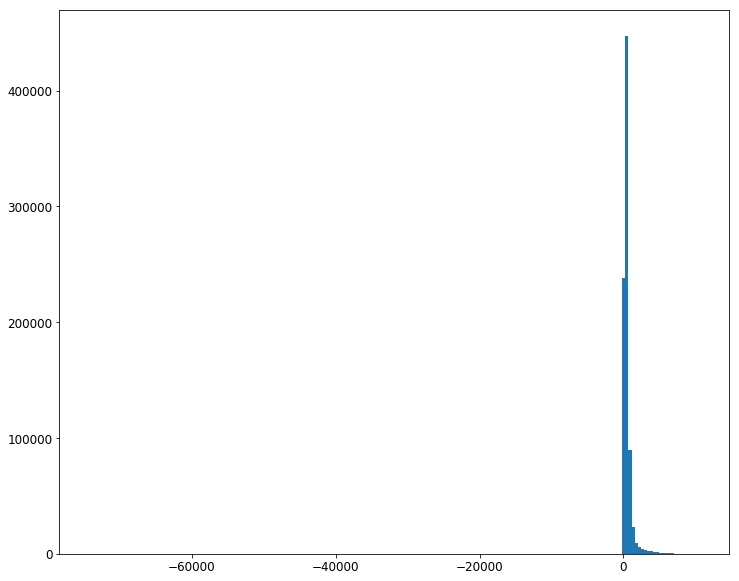

In [17]:
plt.hist(df['job_days'], bins=200)
plt.show()

In [18]:
df['job_days'].describe()

count    832955.000000
mean        496.606339
std         908.138820
min      -74144.000000
25%         243.000000
50%         365.000000
75%         468.000000
max       10422.000000
Name: job_days, dtype: float64

In [19]:
#cases job start day later than expiration day
len(df['job_days'][df['job_days']<0])

543

In [20]:
df = df[df['job_days']>0]
df = df[df['job_days']<2000]

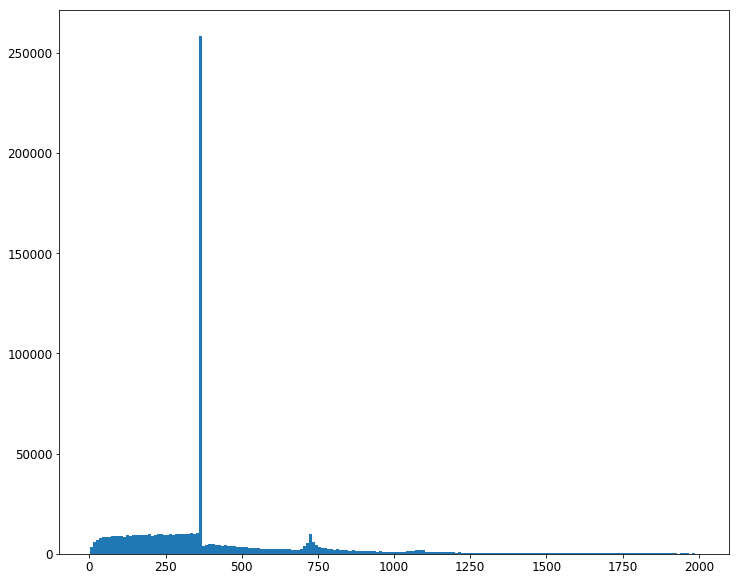

In [21]:
plt.hist(df['job_days'], bins=200)
plt.show()

In [22]:
#cases last exactly 1 year
len(df[df['job_days']==365])

253016

In [23]:
#cases by zip code
dfzip = df.groupby('Zip Code').count()
dfzip.reset_index(inplace=True)
dfzip = dfzip[['Zip Code', 'BOROUGH']]
dfzip.rename(columns={'Zip Code': 'zip_code',
                      'BOROUGH': 'case_count'}, inplace=True)
dfzip.head()

,zip_code,case_count
0,0,13
1,950,3
2,4452,2
3,10000,16
4,10001,12575


#### map

In [24]:
os.system("curl -O http://catalog.civicdashboards.com/dataset/11fd957a-8885-42ef-aa49-5c879ec93fac/resource/28377e88-8a50-428f-807c-40ba1f09159b/download/nyc-zip-code-tabulation-areas-polygons.geojson")
os.system("mv " + "nyc-zip-code-tabulation-areas-polygons.geojson " + os.getenv("PUIDATA"))
nyc = gpd.read_file(os.getenv("PUIDATA") + "/" + 'nyc-zip-code-tabulation-areas-polygons.geojson')

In [25]:
nyc['zip_code'] = nyc.postalCode.astype(str)
nyc.drop(['OBJECTID', 'postalCode', 'PO_NAME', 'STATE', 'borough', 'ST_FIPS',
          'CTY_FIPS', 'BLDGpostal', '@id', 'longitude', 'latitude'], axis=1, inplace=True)

In [26]:
mapData = pd.merge(nyc, dfzip, on='zip_code').drop_duplicates('zip_code')
mapData.head()

,geometry,zip_code,case_count
0,POLYGON ((-73.86942457284177 40.74915687096788...,11372,532
1,POLYGON ((-73.71132911125308 40.74947450816085...,11004,254
2,POLYGON ((-73.70098278625547 40.73889569923034...,11040,70
3,POLYGON ((-73.72270447144122 40.75373371438336...,11426,270
4,"POLYGON ((-73.81088634744756 40.7271718757592,...",11365,584


In [27]:
mapData.crs = from_epsg(4326) #from lat/long
mapData['geometry'] = nyc.to_crs(epsg=2263).geometry
mapData = gpd.GeoDataFrame(mapData)

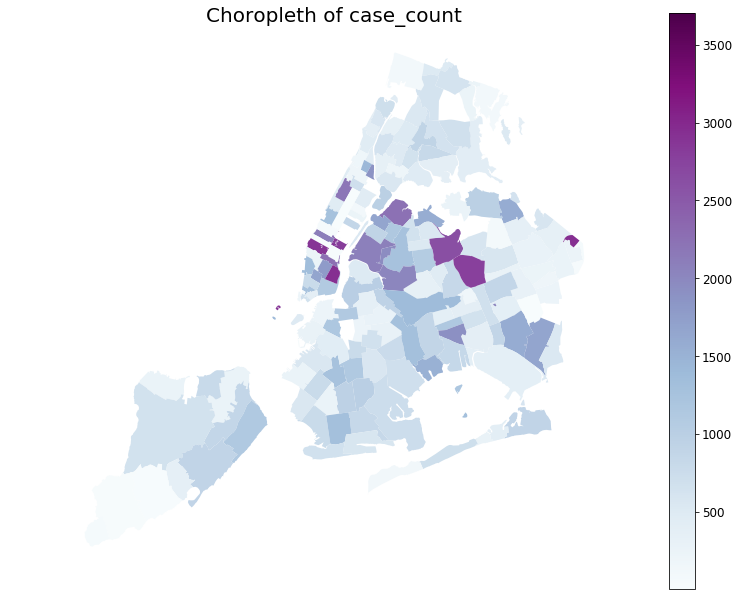

In [28]:
name = 'case_count'
ax = mapData.plot(column='{}'.format(name), cmap='BuPu', alpha=1)
vmin, vmax = min(mapData['{}'.format(name)].values), max(mapData['{}'.format(name)].values)
ax.axis('off')
ax.set_title('Choropleth of {}'.format(name), size=20)
fig = ax.get_figure()
cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
sm = plt.cm.ScalarMappable(cmap='BuPu', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
fig.colorbar(sm, cax=cax)
plt.savefig('Figure2', dpi=300, transparent=True)
plt.show()